# FedEx: Las Vegas Deliveries

### Introduction

This notebook, based on several online tutorials, is meant to be a basic example of the Clark Wright savings algorithm, as applied for deliveries from a single hun to locations in the Las Vegas area. Please note I did not overlay the road system with Google API, but merely assumes direct travel from hub to nodes and back for simplicity. 

The constraints and assumptions on the underlying data can be found in the formulas of the accompanying dataset, but here are some examples:

    -Three trucks:
        Truck A has total capacity of 10, and gets 13-18 mpg.
        Truck B has total capacity of 8, and gets 15-19 mpg.
        Truck C has total capacity of 5, and gets 3-5 kWpm (electric).
    -Gas cost varies between $3-6/gallon, electricity fixed at $0.15/kW.
    -Labor cost is fixed at $20/hour
    -Assumption is that drivers move at an average of 30 mph.
    -15 separate locations in Las Vegas area, with the same weighted delivery for each location.
    -Two months worth of deliveries, 500 in total.

Here are the cost functions for each truck __(y = mx^(1-n))__:

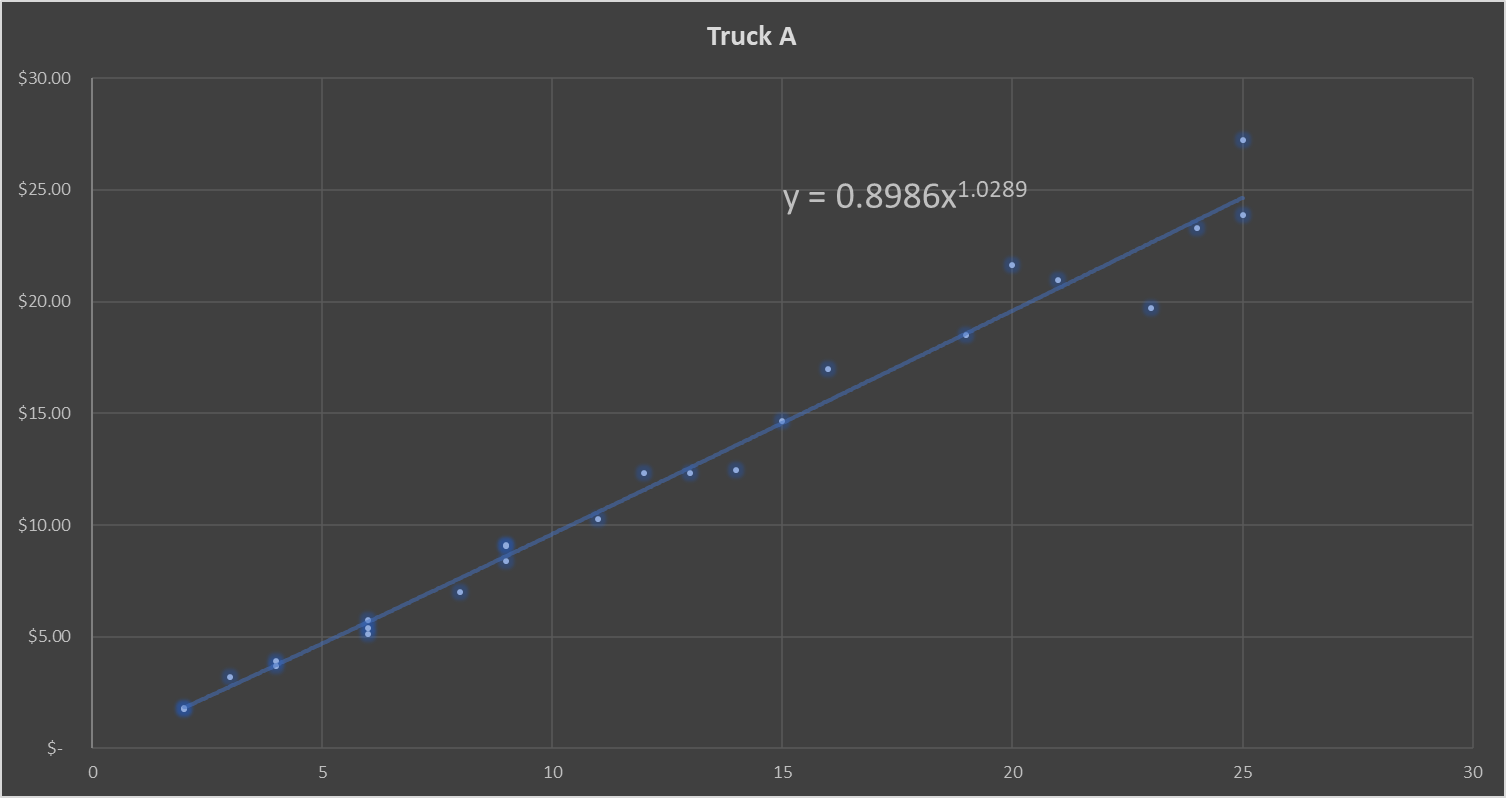
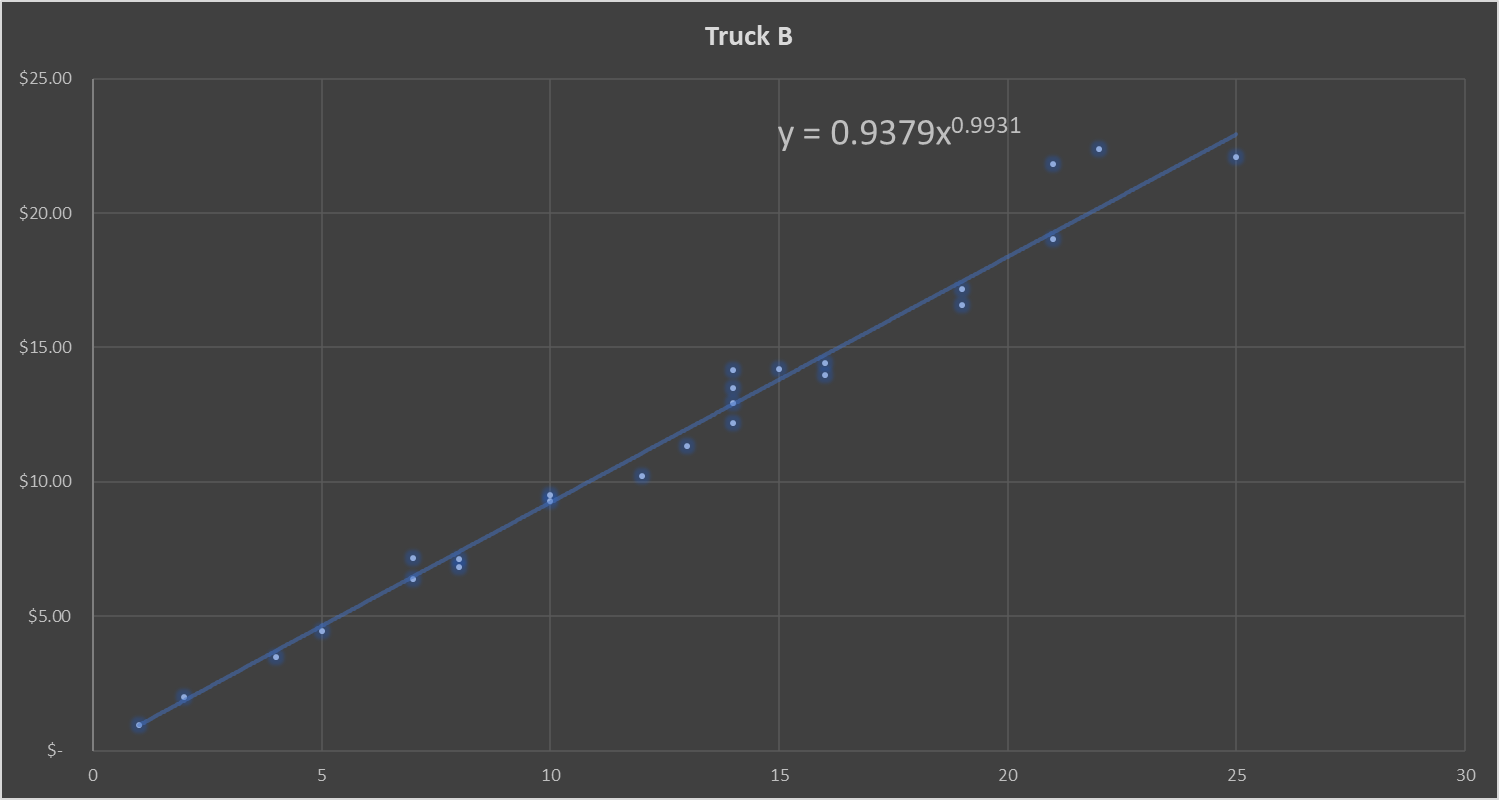
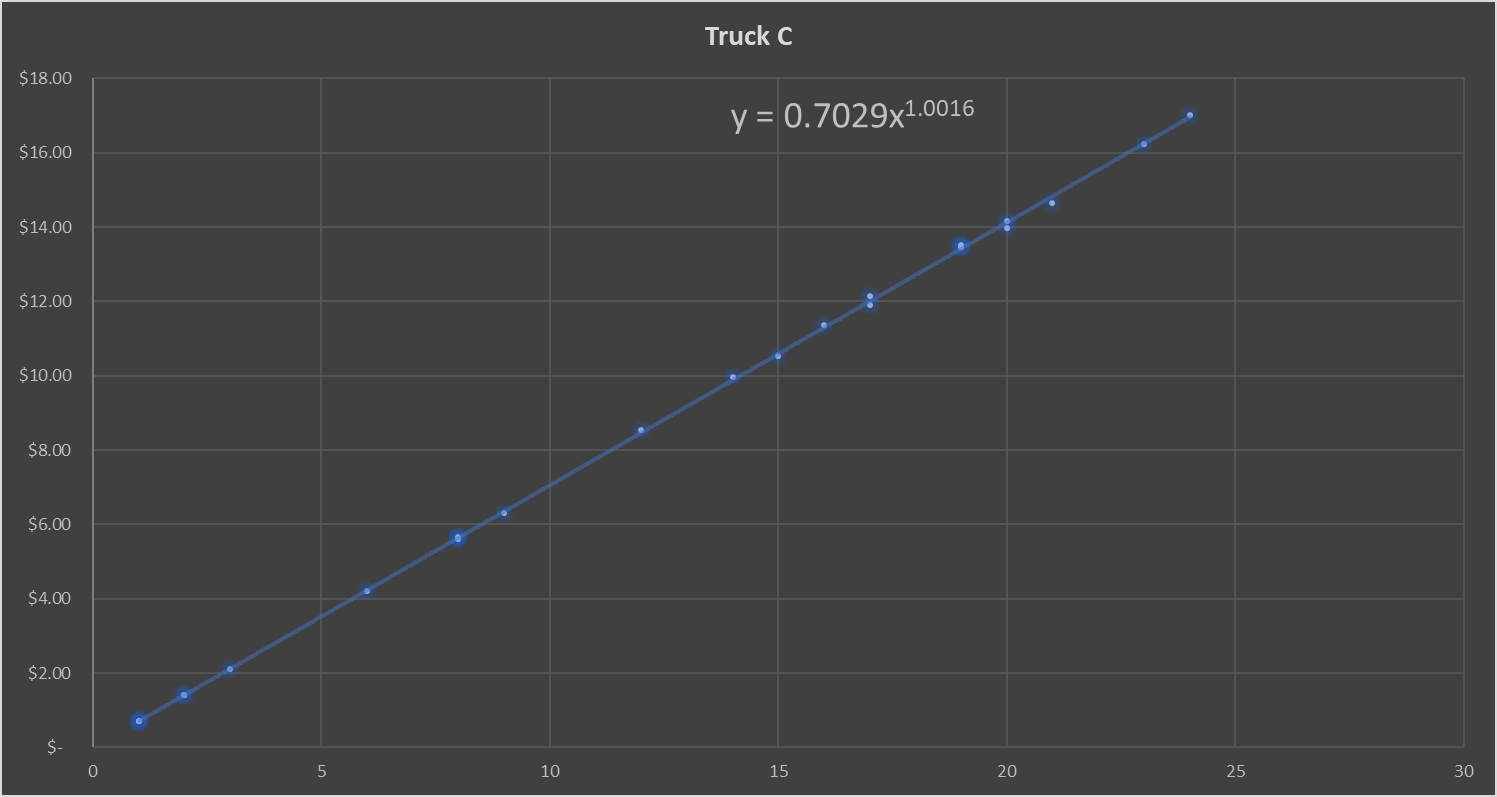

In [1]:
import numpy as np

Truck_list = [['A', 10, 0.8986, -0.0289],
              ['B', 8, 0.9379, 0.0069],
              ['C', 5, 0.7029, -0.0016]]

sorter_guide = []

max_truck_capacity = 0

for i in range(len(Truck_list)):
    sorter_guide.append([i, int(Truck_list[i][1])])
    if int(Truck_list[i][1]) >= max_truck_capacity:
        max_truck_capacity = int(Truck_list[i][1])
sorter_guide = np.array(sorter_guide)
sorter_guide = sorter_guide[sorter_guide[:,1].argsort()[::-1]]
sorter_temp = []

for i in range(len(sorter_guide)):
    sorter_temp.append(Truck_list[sorter_guide[i][0]])

Truck_list = np.array(sorter_temp)   

print('\n',"max_truck_capacity =",max_truck_capacity,'\n')
Truck_list


 max_truck_capacity = 10 



array([['A', '10', '0.8986', '-0.0289'],
       ['B', '8', '0.9379', '0.0069'],
       ['C', '5', '0.7029', '-0.0016']], dtype='<U32')

## Let's look at the dataset

The csv file is included on the FedEx GitHub page.

The first tab labeled __'Deliveries'__ is the full dataset on which we will run the simulation with shape (500,5), and follows the parameter outlined above. 

The next three tabs calculate cost functions for each truck with their separate constraints, charts above describing the same. There is also a __'Trucks'__ tab which summarizes __m & b__ for each truck.

Finally there is a __'rand data'__ tab which provides unique values for each of the five features, to make calling easier from this notebook.

In [2]:
import pandas as pd
df = pd.read_excel('trux.xlsx',sheet_name = 'Deliveries')
df

,Date,Location,Latitude,Longitude,Weight
0,2023-06-21,Location 15,36.015227,-115.136941,12.627326
1,2023-07-21,Location 11,36.261824,-114.863869,9.415903
2,2023-07-04,Location 14,35.954698,-115.252443,11.732146
3,2023-06-20,Location 13,36.212549,-115.113713,11.172734
4,2023-07-10,Location 14,36.261824,-115.041135,8.469263
...,...,...,...,...,...
495,2023-08-05,Location 3,36.140476,-115.252443,7.440683
496,2023-07-24,Location 7,36.031776,-114.940866,6.613489
497,2023-07-09,Location 4,36.080865,-115.113713,14.889736
498,2023-08-10,Location 4,36.060911,-115.136941,12.627326


## Visualizing the Delivery Locations

In [3]:
df_locations = pd.read_excel('trux.xlsx', sheet_name = 'rand data', usecols = 'B:D', nrows = 15)
df_locations

,Location,lat,lon
0,Location 1,36.080865,-115.128101
1,Location 2,36.128031,-115.116429
2,Location 3,36.031776,-115.049082
3,Location 4,36.230767,-115.252443
4,Location 5,36.261824,-115.113713
5,Location 6,36.208246,-115.030617
6,Location 7,36.207871,-115.041135
7,Location 8,36.140476,-115.273677
8,Location 9,36.079104,-115.136941
9,Location 10,36.060911,-115.118218


In [4]:
import folium
import pandas as pd

df_map = pd.read_excel('trux.xlsx', sheet_name = 'rand data', usecols = 'C:D', nrows = 15)
m = folium.Map(location=[36.145283, -115.152068]) #center location
for index, row in df_map.iterrows():
    folium.Marker(location=[row['lat'], row['lon']]).add_to(m)
m

## Calculate Distances  - Geodesic

In [5]:
from math import sin, cos, sqrt, atan2, radians

def distance_calc(lat_1, lon_1, lat_2, lon_2):
    R = 3958.8 #radius of Earth in miles
    
    lat_1 = radians(lat_1)
    lon_1 = radians(lon_1)
    lat_2 = radians(lat_2)
    lon_2 = radians(lon_2)
    
    dist_lon = lon_2 - lon_1
    dist_lat = lat_2 - lat_1
    
    a = sin(dist_lat / 2) ** 2 + cos(lat_1) * cos(lat_2) * sin(dist_lon / 2) **2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    
    distance = R * c
    
    return distance

## The Clark Wright Algorithm - Primer on math here: 
http://web.mit.edu/urban_or_book/www/book/chapter6/6.4.12.html

In [13]:
def truck_assign(loc_list, weights, status):
    dist_matrix = [[distance_calc(loc_list[i][0], loc_list[i][1], loc_list[j][0], loc_list[i][1]) for i in range(len(loc_list))] for j in range(len(loc_list))]
    dist_matrix = np.array(dist_matrix)
    
    savings_matrix = [[(dist_matrix[0][i + 1] + dist_matrix[0][j + 1] - min(dist_matrix[0][i + 1], dist_matrix[0][j + 1]) - dist_matrix[i + 1][j + 1]) for i in range(len(loc_list) - 1)] for j in range(len(loc_list) - 1)]
    if status == True:
        savings_threshold = 0.42
    else:
        savings_threshold = 0.5
        
    savings_percent_matrix = [[((dist_matrix[0][i + 1] + dist_matrix[0][j + 1] - min(dist_matrix[0][i + 1], dist_matrix[0][j + 1]) - dist_matrix[i + 1][j + 1]) / (dist_matrix[0][i + 1] + dist_matrix[0][j + 1])) for i in range(len(loc_list) - 1)] for j in range(len(loc_list) - 1)]
        
    savings_matrix = np.array(savings_matrix)
    
    for i in range(len(savings_matrix)):
        savings_matrix[i][i] = 0
    
    for i in range(len(savings_percent_matrix)):
        savings_percent_matrix[i][i] = 0
        
    savings_list = []
        
    for i in range(len(savings_matrix)):
        j = 0
        while j < i:
            if savings_percent_matrix[i][j] >= savings_threshold:
                savings_list.append([i + 1, j + 1, savings_matrix[i][j]])
            j = j + 1
    savings_list = np.array(savings_list)
        
    if(len(savings_list) > 0):
        savings_list = savings_list[savings_list[:,2].argsort()[::-1]]
        
    truck_assign_savings = []
        
    for i in range(len(savings_list)):
        truck_assign_savings.append([savings_list[i][0],savings_list[i][1],savings_list[i][2],0,0,0])

    truck_assign_savings = np.array(truck_assign_savings)
    #print('\n',truck_assign_savings)
    
    truck_assign_matrix = np.zeros((len(weights), len(weights)))
    truck_assigned_weights = np.zeros((len(weights)))
    truck_assigned_savings = np.zeros((len(weights)))

    truck_count = 0

    for i in range(len(truck_assign_savings)):
        loc1 = int(truck_assign_savings[i][0])
        loc2 = int(truck_assign_savings[i][1])
        truck_no = 0

        if truck_assign_savings[i][3] == 0 and truck_assign_savings[i][4] == 0:
            if weights[int(loc1-1)] + weights[int(loc2 - 1)] <= max_truck_capacity:
                truck_no = truck_count
                truck_count = truck_count + 1
                truck_assign_matrix[int(loc1-1)][int(truck_no)] = 1
                truck_assign_matrix[int(loc2-1)][int(truck_no)] = 1
                truck_assign_savings[i][3] = 1
                truck_assign_savings[i][4] = 1
                truck_assign_savings[i][5] = truck_no + 1
                truck_assigned_savings[int(truck_no)] = truck_assigned_savings[int(truck_no)] + truck_assign_savings[i][2]

                for j in range(len(truck_assign_savings)):
                    if truck_assign_savings[j][0] == loc1 or truck_assign_savings[j][1] == loc1:
                        if truck_assign_savings[j][0] == loc1:
                            truck_assign_savings[j][3] = 1
                            truck_assign_savings[j][5] = truck_no + 1
                        else:
                            truck_assign_savings[j][4] = 1
                            truck_assign_savings[j][5] = truck_no + 1

                    if truck_assign_savings[j][0] == loc2 or truck_assign_savings[j][1] == loc2:
                        if truck_assign_savings[j][0] == loc2:
                            truck_assign_savings[j][3] = 1
                            truck_assign_savings[j][5] = truck_no + 1
                        else:
                            truck_assign_savings[j][4] = 1
                            truck_assign_savings[j][5] = truck_no + 1

        elif truck_assign_savings[i][3] == 1 and truck_assign_savings[i][4] == 1:
            null = 0
        elif truck_assign_savings[i][3] + truck_assign_savings[i][4] == 1:
            truck_no = truck_assign_savings[i][5] - 1

            if truck_assign_savings[i][3] == 0:
                loc1 = truck_assign_savings[i][0]
            else:
                loc1 = truck_assign_savings[i][1]


            if truck_assigned_weights[int(truck_no)] + weights[int(loc1-1)] <= max_truck_capacity:
                truck_assign_matrix[int(loc1-1)][int(truck_no)] = 1
                truck_assign_savings[i][3] = 1
                truck_assign_savings[i][4] = 1
                truck_assigned_savings[int(truck_no)] = truck_assigned_savings[int(truck_no)] + truck_assign_savings[i][2]
                for j in range(len(truck_assign_savings)):
                    if truck_assign_savings[j][0] == loc1 or truck_assign_savings[j][1] == loc1:
                        if truck_assign_savings[j][0] == loc1:
                            truck_assign_savings[j][3] = 1
                            truck_assign_savings[j][5] = truck_no + 1
                        else:
                            truck_assign_savings[j][4] = 1
                            truck_assign_savings[j][5] = truck_no + 1

        for i in range(truck_count):
            current_wt = 0
            for j in range(len(weights)):
                current_wt = current_wt + truck_assign_matrix[j][i] * weights[j]
            truck_assigned_weights[i]=current_wt
    
    dummy_no = 0
    for i in range(len(truck_assign_matrix)):
        assigned = 0
        for j in range(len(weights)):
            assigned = assigned + truck_assign_matrix[i][j]
        if assigned == 1:
            dummy_no =+ 1
        elif assigned > 1:
            #print("Location no:",i+1,"some error has occurred")
            dummy_no =+ 1
        elif assigned == 0:
            #print("Location no:",i+1,"has not been assigned yet by CW savings")
            truck_assign_matrix[i][int(truck_count)] = 1
            truck_count = truck_count + 1

    for i in range(truck_count):
        current_wt = 0
        for j in range(len(weights)):
            current_wt = current_wt + truck_assign_matrix[j][i] * weights_list[j]
        truck_assigned_weights[i] = current_wt


    truck_assigned_distances = np.zeros((len(weights)))

    for i in range(len(truck_assigned_distances)):
        for j in range(len(truck_assign_matrix)):
            if truck_assign_matrix[j][i] == 1:
                truck_assigned_distances[i] = truck_assigned_distances[i] + dist_matrix[j+1][0]
        truck_assigned_distances[i] = truck_assigned_distances[i] - truck_assigned_savings[i]

    #print(2*'\n',np.array(distance_matrix))
    #print(2*'\n',np.array(cw_savings_matrix))  
    #print(2*'\n',np.array(cw_savings_list))

    #print('\n',"Assignment matrix:",'\n',truck_assignment_matrix,2*'\n',"Number of trucks:",truck_count,2*'\n',"Truck weight matrix:",truck_assigned_weights,2*'\n',"Truck savings:",truck_assigned_savings,2*'\n',"Truck Distances:",truck_assigned_distances)

    truck_assigned_type = np.zeros((len(weights)))

    for i in range(len(truck_assigned_distances)):
        for j in range(len(Truck_list)):
            if(truck_assigned_weights[i] > 0 and truck_assigned_weights[i] <= int(Truck_list[j][1])):
                truck_assigned_type[i] = j + 1
    
    truck_type_counter = []
    
    for p in range(len(Truck_list)):
        count = 0
        for j in range(len(truck_assigned_type)):
            if truck_assigned_type[j] == p + 1:
                count = count + 1
        truck_type_counter.append(count)

    truck_costs = np.zeros((len(weights)))

    for i in range(len(truck_costs)):
        if truck_assigned_type[i] > 0 and truck_assigned_distances[i] > 0:
            k = int(truck_assigned_type[i] - 1)
            truck_costs[i] = round(float(truck_assigned_distances[i]) * float(Truck_list[k][2]) * (float(truck_assigned_distances[i]) ** (float(Truck_list[k][3]) * -1)),1)

    #print('\n',"Truck costs:",truck_costs)
    
    #print(cw_savings_percent_matrix[0])
    return(sum(truck_costs),truck_count,truck_type_counter)

## Weight Distributions

,Weight
Location,
Location 14,434.250032
Location 3,410.284428
Location 13,395.341540
Location 12,367.780492
Location 2,365.960393
Location 5,365.479395
Location 7,354.136450
Location 6,353.218440
Location 15,340.060466


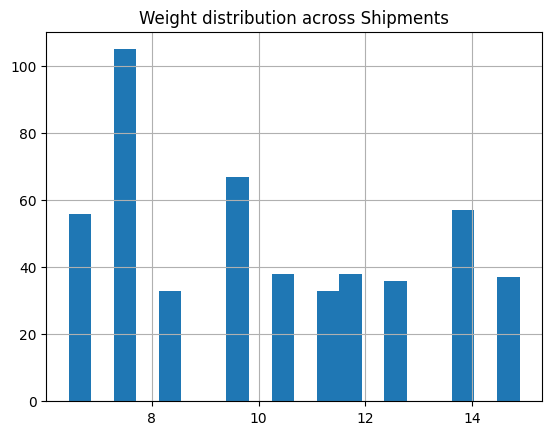

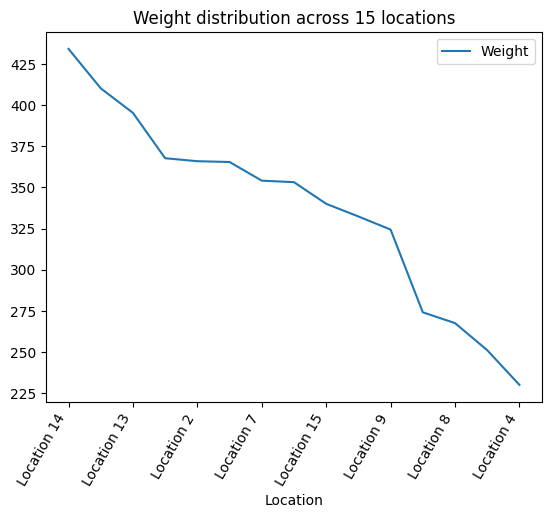

In [14]:
import matplotlib.pyplot as plt

df['Weight'].hist(bins = 20)
plt.title('Weight distribution across Shipments')

location_display = pd.DataFrame(df.groupby(['Location'], as_index = False)['Weight'].sum())
location_display.set_index('Location', inplace = True)

location_display = location_display.sort_values(by = 'Weight', ascending = False)
location_display.head(15).plot(title='Weight distribution across 15 locations')
plt.xticks(rotation = 60, ha = 'right')

location_display

## Segregating Deliveries by Weight

In [15]:
import numpy as np
from datetime import datetime, timedelta, date
import warnings
warnings.filterwarnings("ignore")

dda = pd.DataFrame(df.groupby(['Date','Location','Latitude','Longitude'], as_index = False)['Weight'].sum())
df.tail(20)

job_status = 0

for i in range(len(dda)):
    if dda['Weight'][i] > max_truck_capacity:
        remainder = dda['Weight'][i] % max_truck_capacity
        no_of_splits = int(dda['Weight'][i] / max_truck_capacity - remainder / max_truck_capacity)
        #print(dda['Weight'][i],no_of_splits,remainder)
        dda['Weight'][i] = remainder
        gg = dda[dda.index == i]
        gg['Weight'][i] = max_truck_capacity
        for j in range(no_of_splits):
            dda = dda.append(gg, ignore_index = True)

df_new = pd.DataFrame(dda)
df_new['Date'] = pd.to_datetime(df_new['Date'], format = '%d-%m-%Y')

source_Latitude_list = np.array(df['Latitude'])
source_Longitude_list = np.array(df['Longitude'])
weights_list = np.array(df['Weight'])
source_dates = np.array(df['Date'])

delta = timedelta(days = 1)

no_of_days = int((max(df_new['Date']) - min(df_new['Date'])).days + 1)

print('The number of new deliveries based on the weight distribution and truck capacity is:',len(df_new))
df_new

The number of new deliveries based on the weight distribution and truck capacity is: 710


,Date,Location,Latitude,Longitude,Weight
0,2023-06-12,Location 11,36.015227,-114.863869,0.262323
1,2023-06-12,Location 2,36.079104,-115.136941,9.624671
2,2023-06-12,Location 3,36.266401,-115.136941,4.889736
3,2023-06-12,Location 6,36.140476,-115.030617,4.889736
4,2023-06-12,Location 6,36.207871,-115.128101,1.732146
...,...,...,...,...,...
705,2023-08-11,Location 5,36.031776,-115.128101,10.000000
706,2023-08-11,Location 6,36.079104,-115.252443,10.000000
707,2023-08-11,Location 7,36.140476,-114.940866,10.000000
708,2023-08-11,Location 8,36.100257,-115.156120,10.000000


## Starting Location & Timeframe

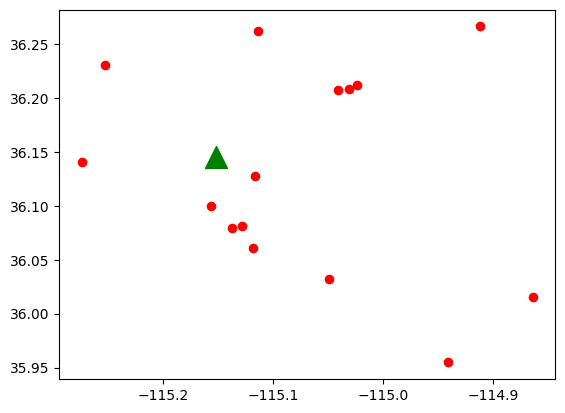

In [16]:
source_coordinates = [36.145283, -115.152068]
planning_horizon = 1      # Enter the no. of days you want to plan together, only intergers >=1

plt.scatter(df_locations['lon'],df_locations['lat'] ,marker = 'o', s = 35, c = 'red')
plt.scatter(source_coordinates[1],source_coordinates[0], marker = '^', s = 250, c = 'green')

## Simulating the Deliveries

___Result :- 

Estimated Cost with no Vehicle Routing: 1410.0
Estimated Cost with Vehicle Routing: 1250.0 

Estimated Cost Savings with Vehicle Routing: 11.3 % 

No. of Trucks with no VR: 276
No. of Trucks with VR: 247


<Axes: xlabel='Capacity'>

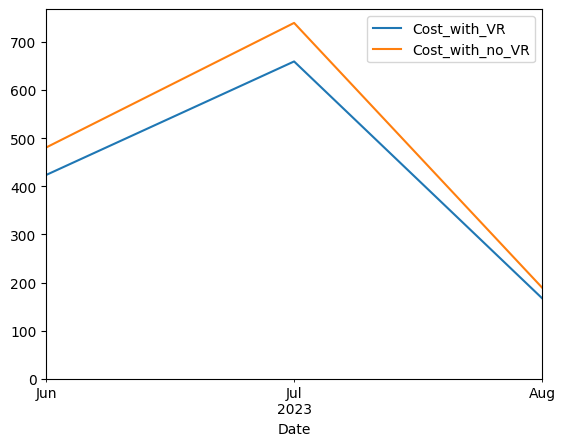

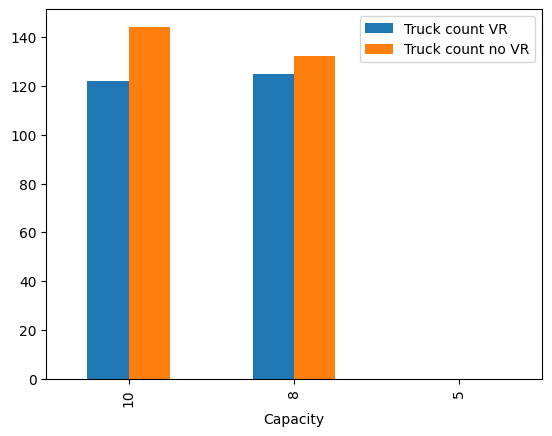

In [17]:
from IPython.display import clear_output

result_matrix = []
truck_type_count_VR = []
for p in range(len(Truck_list)):
    truck_type_count_VR.append(0)

truck_type_count_noVR = []
for p in range(len(Truck_list)):
    truck_type_count_noVR.append(0)

truck_type_count_VR = np.array(truck_type_count_VR)
truck_type_count_noVR = np.array(truck_type_count_noVR)


for j in range(0, no_of_days, planning_horizon):
    
    clear_output(wait = True)
    print("____Simulation Progress :", round(100 * j / no_of_days, 1),"%")
    weights_temp = []
    locations_temp = [[source_coordinates[0], source_coordinates[1]]]
    range_start = min(df_new['Date']) + j * delta
    range_end = min(df_new['Date']) + (j + planning_horizon) * delta
    
    rslt_df = df_new[df_new['Date'] >= range_start]
    rslt_df = rslt_df[rslt_df['Date'] < range_end]
    #print(rslt_df.iloc[0,'Latitude'])
    
    
    for i in range(len(rslt_df)):
        locations_temp.append([rslt_df.iloc[i]['Latitude'], rslt_df.iloc[i]['Longitude']])
        weights_temp.append(rslt_df.iloc[i]['Weight'])
    if len(locations_temp) > 1:
        result_output_vr = truck_assign(locations_temp, weights_temp, True)
        result_output_no_vr = truck_assign(locations_temp, weights_temp, False)
        result_matrix.append([range_start,result_output_vr[0], result_output_no_vr[0]])
        truck_type_count_VR = np.add(truck_type_count_VR, np.array(result_output_vr[2]))
        truck_type_count_noVR = np.add(truck_type_count_noVR, np.array(result_output_no_vr[2]))
    
clear_output(wait = True)
result_matrix

df_final = pd.DataFrame(result_matrix, columns=['Date', 'Cost_with_VR', 'Cost_with_no_VR'])
df_final = df_final.set_index('Date')

Truck_list_table = pd.DataFrame(Truck_list, columns = ['Name','Capacity','m','b'])
Truck_list_table.drop(['m','b'], 1)
Truck_list_table['Truck count VR'] = pd.Series(truck_type_count_VR)
Truck_list_table['Truck count no VR'] = pd.Series(truck_type_count_noVR)


print("___Result :-",'\n')
print("Estimated Cost with no Vehicle Routing:", round(sum(df_final['Cost_with_no_VR']), 0))
print("Estimated Cost with Vehicle Routing:", round(sum(df_final['Cost_with_VR']), 0), '\n')
#print('\n')
print("Estimated Cost Savings with Vehicle Routing:", round((sum(df_final['Cost_with_no_VR']) - sum(df_final['Cost_with_VR'])) * 100 / sum(df_final['Cost_with_no_VR']), 1), "%", '\n')
print("No. of Trucks with no VR:", sum(Truck_list_table['Truck count no VR']))
print("No. of Trucks with VR:", sum(Truck_list_table['Truck count VR']))

df_final.resample('M').sum().plot().axis([None, None, 0, None])
Truck_list_table.plot.bar(x = 'Capacity')